In [2]:
# ! pip install --upgrade pip
# ! pip install --upgrade git+https://github.com/oda-hub/oda_api@request-list pandas
# ! pip install linked-data-latex
# ! pip install ruamel.yaml
# ! pip install pymosaic-fits


import oda_api.api
import oda_api.token
import oda_api.plot_tools
import requests
import logging
from matplotlib import pylab as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import pandas as pd
import numpy as np
from ddpaper.draftdata import DraftData
import io

# https://gcn.gsfc.nasa.gov/gcn3/32634.gcn3

In [3]:
# oda:version "dev1.1.22"

In [4]:
#TODO: statistics on odaf failures at the and of compute

In [5]:
# #slightly more verbose
logging.getLogger().setLevel(logging.INFO)
# #all messages
#logging.getLogger().setLevel(logging.DEBUG)

logging.getLogger('oda_api').addHandler(logging.StreamHandler())

In [6]:
# 120711 https://www.aanda.org/articles/aa/pdf/2014/07/aa20872-12.pdf
# https://www.cosmos.esa.int/web/integral/schedule-information

In [7]:
from matplotlib import pylab as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import pandas as pd
import numpy as np

In [8]:
T0_isot = "2022-10-09T13:17:00"
T0_ijd = Time(T0_isot, scale='utc').tt.mjd - 51544

src_coord = SkyCoord("19h 13m 03.43s", "+19d 46m 23.1s", unit=u.deg)
source_name = "GRB221009A"
src_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (288.26429167, 19.77308333)>

In [9]:
float(Time(51544, format='mjd', scale='ut1').mjd) - Time(51544, format='mjd', scale='tai').mjd

0.0

In [10]:
with DraftData() as dd:
    dd['sc'] = requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/scsystem/api/v1.0/sc/{T0_isot}/{src_coord.ra.deg}/{src_coord.dec.deg}").json()
    dd['sc_second_pointing'] = requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/scsystem/api/v1.0/sc/{Time(Time(T0_isot).mjd + 700./24/3600, format='mjd').isot}/{src_coord.ra.deg}/{src_coord.dec.deg}").json()

dd['sc']['theta'],dd['sc_second_pointing']['theta']

(65.81131216259752, 67.68686829882438)

In [11]:
acslc_r = requests.get(f"https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//integralhk/api/v1.0/genlc/ACS/{T0_ijd}/2000")
import pandas as pd
import io

acslc = pd.read_csv(io.StringIO(acslc_r.text), skiprows=5, names=['t', 'dt', 'c', 'ds'], delim_whitespace=True)
acslc

,t,dt,c,ds
0,8317.531125,0.001364,5264.0,45820.001364
1,8317.531125,0.051363,5102.0,45820.051363
2,8317.531126,0.101364,5234.0,45820.101364
3,8317.531127,0.151363,5374.0,45820.151363
4,8317.531127,0.201365,5244.0,45820.201364
...,...,...,...,...
79995,8317.577418,3999.754042,5322.0,49819.754042
79996,8317.577419,3999.804041,5130.0,49819.804041
79997,8317.577419,3999.854042,5376.0,49819.854042
79998,8317.577420,3999.904042,5426.0,49819.904041


In [12]:
src_coord = SkyCoord("19h 13m 03.43s", "+19d 46m 23.1s", unit=u.deg)
source_name = "GRB221009A"
src_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (288.26429167, 19.77308333)>

In [13]:
import subprocess
import io
import pathlib
from astropy.io import fits

def sshopen(fn):
    cfn = pathlib.Path("/tmp/sshopen-cache/") / fn.replace("/", "_")
    cfn.parent.mkdir(exist_ok=True)

    try:
        of = fits.open(cfn)
    except:
        f = io.BytesIO(subprocess.check_output(f"ssh login01.astro.unige.ch tar cf - {fn} | tar xf - -O", shell=True))

        with open(cfn, "wb") as F:
            F.write(f.read())
        
        of = fits.open(cfn)
    return of

sshopen("/isdc/arc/rev_3/scw/2558/255800290010.001/compton_events.fits.gz")


[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f8bea872430>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f8bea872070>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f8bea872f40>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f8bea85eb20>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f8bea85e2e0>]

In [14]:
sshopen("/isdc/arc/rev_3/scw/2558/255800290010.001/compton_events.fits.gz")

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f8bea8a9580>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f8bea8726d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f8bea872790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f8bea872640>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f8bea85e7f0>]

In [55]:
ijd2plot = lambda T: (T - T0_ijd)*24*3600
ijd2plot_d = lambda T: (T - T0_ijd)

In [17]:
T0_pointing_coord = dd['sc']['scx']
T0_pointing_coord

{'dec': -41.012, 'ra': 261.096}

In [18]:
mce = dict()

for i in range(8):
    mce[i] = pd.read_csv(
        io.StringIO(requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/integralhk/api/v1.0/genlc/ISGRIRAW_MCE{i}/{T0_ijd}/2000").text), 
        skiprows=5, names=['t', 'dt', 'c', 'ds'], delim_whitespace=True)


np.sum([mce[i].c for i in range(8)], axis=0)

array([9336, 9440, 9537, ..., 9326, 9397, 9508])

In [19]:
scw_dict_prompt = pd.DataFrame(requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/{T0_ijd-500/24/3600}/{T0_ijd+2000/24/3600}?"
             f"ra={src_coord.ra.deg}&dec={src_coord.dec.deg}&radius=200&return_columns=SWID,SW_TYPE,TELAPSE,TSTART,TSTOP").json())


In [20]:
# https://heasarc.gsfc.nasa.gov/docs/integral/ao19-docs-b/AO19_recommended_programme.pdf

In [21]:
# expected isgri raw rate

isgri_pixel_eff_area = u.cm**2 * 0.4*0.4 * 1 # opacity 1 approximate
isgri_mdu_eff_area = 64 * 32* isgri_pixel_eff_area 
isgri_eff_area = 128*128* isgri_pixel_eff_area 

flux_neax_peak = 5e4 * 1e-10 * u.erg/u.cm**2/u.s

print("expected total ISGRI RAW rate =", ((flux_neax_peak * isgri_eff_area)/(u.keV * 200)).to(u.s**-1))
print("expected total ISGRI RAW waiting time =", ((flux_neax_peak * isgri_mdu_eff_area)/(u.keV * 200)).to(u.ms**-1))

expected total ISGRI RAW rate = 40904.353870386076 1 / s
expected total ISGRI RAW waiting time = 5.113044233798259 1 / ms


(0.0, 1000.0)

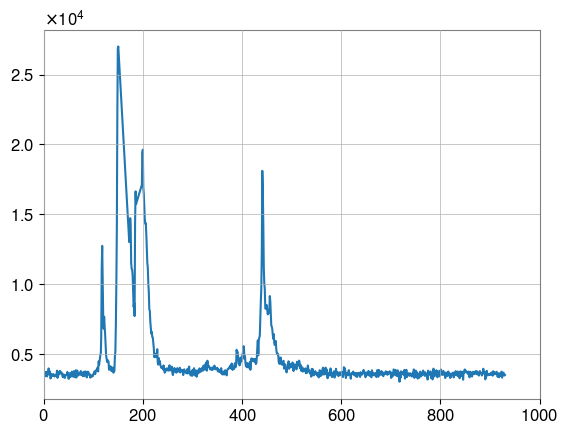

In [22]:
picsit_lc = pd.read_csv("picsit/grb221009a_afterglow_picsit_lc.txt", delim_whitespace=True, names=["mjd", "flux"])
picsit_lc_1s = pd.read_csv("picsit/grb221009a_picsit_lc_1s.txt", delim_whitespace=True, names=["mjd", "flux", "flux_err"])
picist_hr = pd.read_csv("picsit/grb221009a_afterglow_picsit_hr.txt", delim_whitespace=True, names=["mjd", "hr"])

# plt.plot(
#     (picist_hr.mjd - (T0_ijd + 51544))*24, 
#     picist_hr.hr, 
# )

t_since_t0 = np.array(picsit_lc_1s.mjd) - (T0_ijd + 51544)

plt.errorbar(
    t_since_t0*24*3600, 
    picsit_lc_1s.flux
    # (t_since_t0[1:] - t_since_t0[:-1])*24*3600, 
)
plt.xlim([0, 1000])
# plt.ylim([0, 100])

# plt.title('difference between subsequent PICsIT bins in "grb221009a_afterglow_picsit_lc.txt"')
# plt.ylabel('seconds')


# plt.loglog()

first to COMP-SGLE-ALL 270647
adding to COMP-SGLE-ALL 34420
adding to COMP-SGLE-ALL 317446
bkg for COMP-SGLE-ALL = 138.89569629629634


(-5000.0, 60000.0)

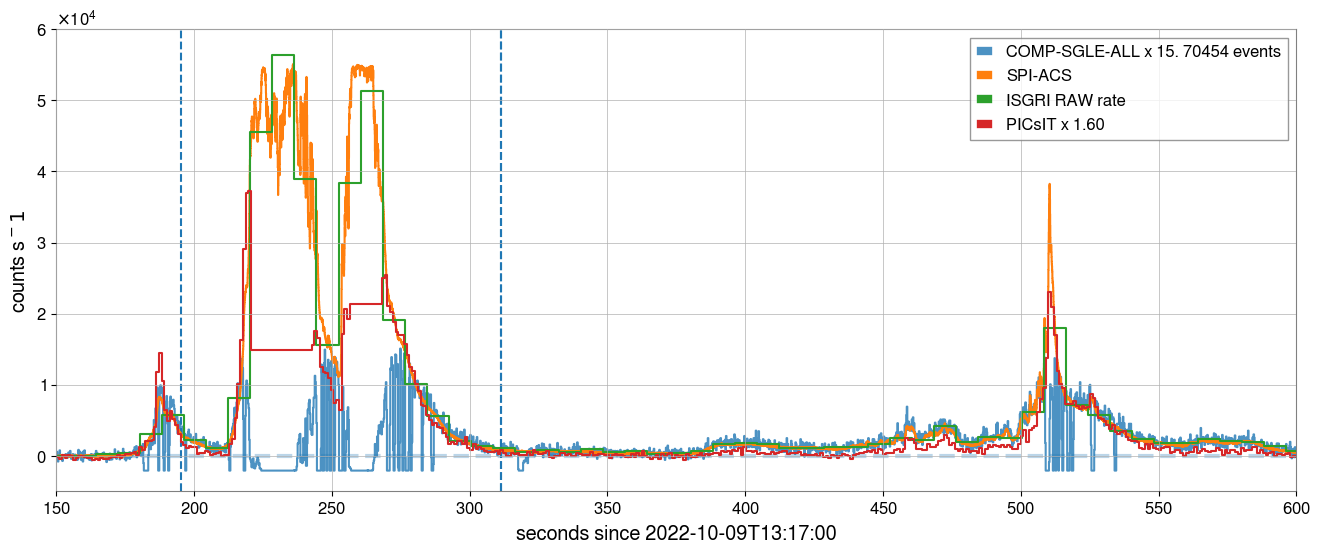

In [23]:
plt.figure(figsize=(16, 6))

from collections import defaultdict

hs_by_et = defaultdict(list)
cs_by_et = defaultdict(list)

compton_event_file = {}
isgri_event_file = {}

events_by_ext = {}

plt.axhline(0, lw=3, ls="--", alpha=0.3)

for i, r in scw_dict_prompt.iterrows():
    scwid = r.SWID

    compton_event_file[scwid]  = sshopen(f"/isdc/arc/rev_3/scw/{scwid[:4]}/{scwid}.001/compton_events.fits.gz")
    isgri_event_file[scwid]  = sshopen(f"/isdc/arc/rev_3/scw/{scwid[:4]}/{scwid}.001/isgri_events.fits.gz")    
    # compton_event_file[scwid]  = sshopen(f"/isdc/pvphase/nrt/ops/scw/{scwid[:4]}/{scwid}.000/compton_events.fits.gz")
    # isgri_event_file[scwid]  = sshopen(f"/isdc/pvphase/nrt/ops/scw/{scwid[:4]}/{scwid}.000/isgri_events.fits.gz")    


    for C, color, ext in [
                    # (isgri_event_file, 'y', "ISGR-EVTS-ALL"),
                    # (compton_event_file, 'g', "COMP-MULE-ALL"),
                    (compton_event_file, 'r', 'COMP-SGLE-ALL')
                ]:
        data = C[scwid][ext].data

        label=ext + " " + scwid
    


        ijd2plot = lambda T: (T - T0_ijd)*24*3600

        if ijd2plot(r.TSTART) > -100:
            plt.axvline(
                ijd2plot(r.TSTART), ls="--",
            )
            plt.axvline(
                ijd2plot(r.TSTOP), ls="--",
            )

            # plt.text(ijd2plot(r.TSTART), 10000, f"{scwid[6:8]}\n{scwid[10:12]}")
            # plt.text(ijd2plot(r.TSTART), 4000, scwid, rotation=90)


        # plt.axvspan(
        #     ijd2plot(r.TSTART),
        #     ijd2plot(r.TSTOP),
        #     alpha=0.2,
        #     color='red'
        # )

        if ext in events_by_ext:
            print("adding to", ext, len(data))
            events_by_ext[ext] = np.concatenate([events_by_ext[ext], data])
        else:
            print("first to", ext, len(data))
            events_by_ext[ext] = data

        
        label = None


for ext, data in events_by_ext.items():
    T = data['TIME']

    Ei = 0
    Ep = 0

    try:
        Ei = data['ISGRI_ENERGY']            
    except:
        pass
    
    try:
        Ep = data['PICSIT_ENERGY']
    except:
        pass

    Ec = Ei + Ep

    h = np.histogram(ijd2plot(T), bins=np.linspace(-10, 800, int(810/0.2)))
    dt = (h[1][1:] - h[1][:-1])
    tc = (h[1][1:] + h[1][:-1]) / 2.
    rate = h[0] / dt

    
    scale = {"ISGR-EVTS-ALL": 3,
             "COMP-MULE-ALL": 100,
             'COMP-SGLE-ALL': 15 }[ext]
    
    b = np.mean(rate[(tc < 150) & (tc > 50) & (rate>0)])

    print("bkg for", ext, "=", b)

    N = np.sum(((rate - b)*dt)[(rate - b>0) & (tc > 100) & (tc <700)])
    
    plt.step(tc, (rate - b)*scale, alpha=0.8, label=f"{ext} x {scale:d}. {N:.0f} events")
    
ijd2plot = lambda t:(t- T0_ijd)*24*3600

# acs_cts2es = 1.5e-10

b = np.mean(acslc.c[(acslc.t- T0_ijd)*24*3600 < 200])
plt.step(ijd2plot(acslc.t), (acslc.c - b)/2, label="SPI-ACS")

isgri_raw_total_rate = np.sum([mce[i].c for i in range(8)], axis=0 )
b = np.mean(isgri_raw_total_rate[(mce[0].t- T0_ijd)*24*3600 < 200])
plt.step((mce[0].t- T0_ijd)*24*3600, isgri_raw_total_rate - b, label="ISGRI RAW rate", where='post')

# picsit

b = np.nanmean(picsit_lc_1s.flux[(picsit_lc_1s.mjd - 51544 - T0_ijd)*24*3600 < 200])

picsit_factor = 1.6
plt.step(
    ijd2plot(picsit_lc_1s.mjd - 51544) + 70, 
    (picsit_lc_1s.flux - b)*picsit_factor, 
    # picsit_lc_1s.flux / 0.8e-9, 
    label=f"PICsIT x {picsit_factor:.2f}"
)

# plt.axhspan(-1e10, 0, color='k', alpha=0.2)
plt.ylim([-1e4, 6e4])

plt.xlabel(f"seconds since {T0_isot}")
plt.ylabel(f"counts s$^{-1}$")

# axy2 = plt.twinx()
# axy2.plot(ijd2plot(att_hist['TIME']), scx.separation(src_coord).deg)
# axy2.scatter(ijd2plot(att_hist['TIME']), scx.separation(src_coord).deg)
# axy2.set_ylim([60,75])

# plt.grid(False)

plt.legend()
plt.ylim([-5e3, 6e4])
plt.xlim([150, 600])
plt.savefig("figs/prompt.pdf")

plt.xlim([250, 400])
plt.savefig("figs/prompt_p1.pdf")

plt.xlim([-10, 10])
plt.ylim([-1e3, 1e3])
plt.savefig("figs/precursor.pdf")


plt.xlim([10, 800])

plt.xlim([150, 600])
# plt.xlim([450, 600])
plt.ylim([-5e3, 6e4])

# plt.xlim([300, 310])
# plt.ylim([-0.5e3, 3e3])


# TODO: also show early one
# TODO: search for smaller excesses allover
# TODO: check if saturation is by ISGRI module, else why smooth transitions in compton rate
# TODO: search for long-term in compton, good sensitivity
# TODO: check detector plane near compton saturations, module?

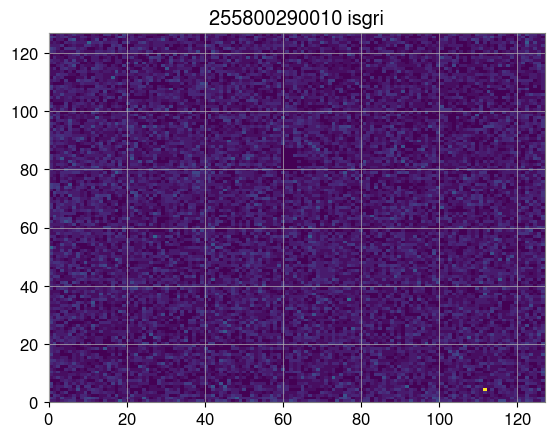

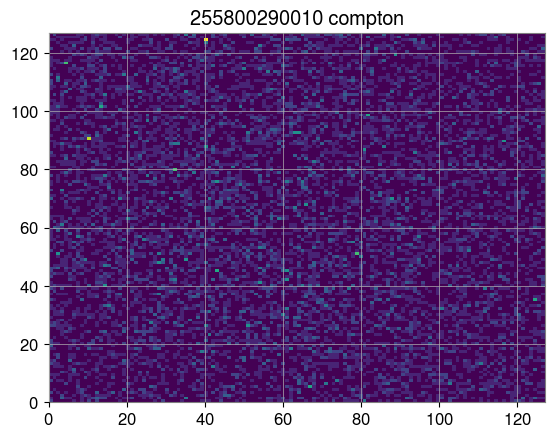

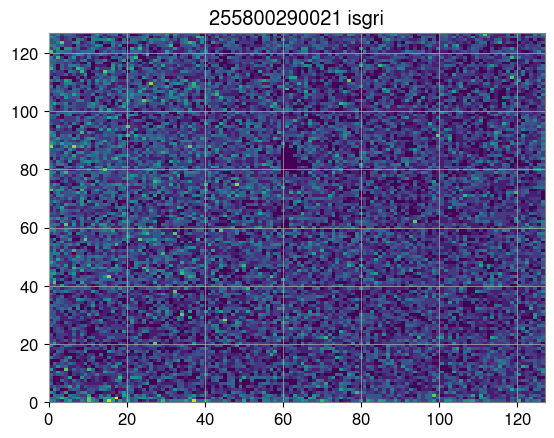

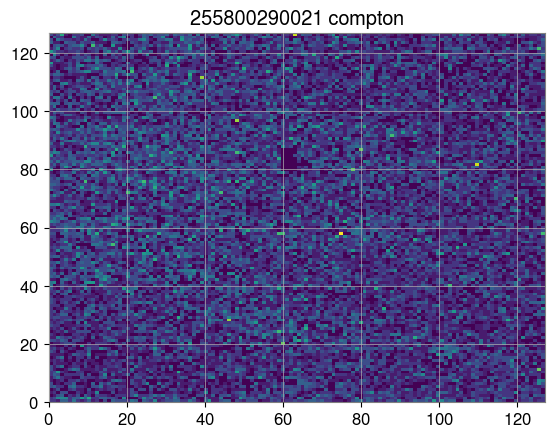

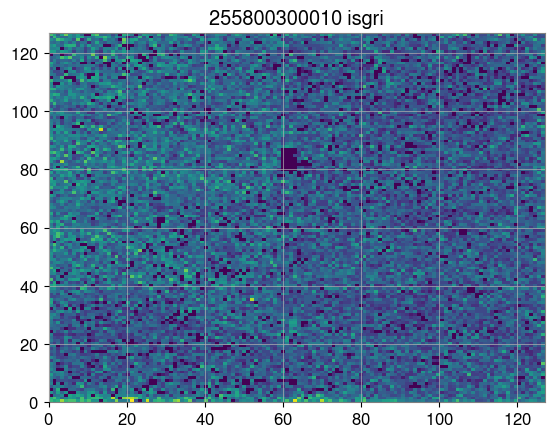

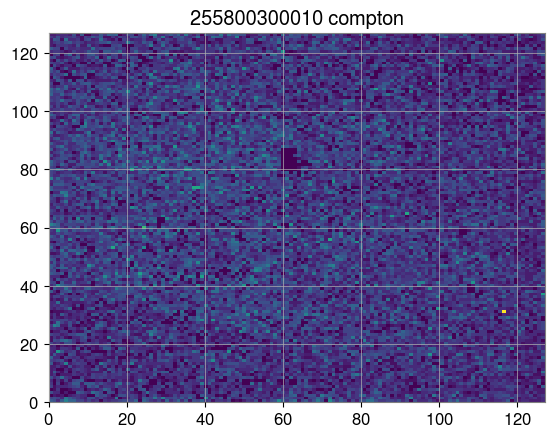

In [51]:

for scwid in isgri_event_file.keys():
    for d, n in [(isgri_event_file[scwid][3].data, 'isgri'), (compton_event_file[scwid]['COMP-SGLE-ALL'].data, 'compton')]:
        plt.figure()

        m = d['TIME'] > T0_ijd + 150./3600./24
        m &= d['TIME'] < T0_ijd + 550/3600./24

        _ = plt.hist2d(d['ISGRI_Y'][m], d['ISGRI_Z'][m], (128, 128))
        plt.title(f"{scwid} {n}")

In [47]:
compton_event_file[scwid][5].header['EXTNAME']

'COMP-SGLE-ALL'

In [25]:
scw_dict_prompt['tstart_since_t0_s'] = ijd2plot(scw_dict_prompt.TSTART)
scw_dict_prompt['tstop_since_t0_s'] = ijd2plot(scw_dict_prompt.TSTOP)

In [26]:
dd['sc']['bodies']['earth']['separation']

137648.7

In [27]:
lc_pdf="figs/prompt.pdf"
lc_p1_pdf="figs/prompt_p1.pdf"
T0_isot=T0_isot
data=dict(dd)
scws=scw_dict_prompt.to_dict()
T0_pointing_coord=dd['sc']['scx']
sc=dd['sc']
sc_second_pointing=dd['sc_second_pointing']
